In [1]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

In [2]:
def plotImage(img, edges = None):
    # plot the image with edges or merely image
    if not edges:
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.gray()
        plt.imshow(img)
    else:
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.gray()
        plt.imshow(img)
        plt.plot()
        l = mlines.Line2D([xmin,xmax], [ymin,ymax])

In [3]:
def plotProfile(profile):
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(range(len(profile)), profile)

In [4]:
def fitProfileAndPlot(profile):
    # define a function to be fitted
    def func(x, a, b):
        return x*a + b 
    
    plotProfile(profile)
    
    # plot the fitted function on the profile
    popt, pcov = curve_fit(func, range(len(profile)), profile)
    popt
    plt.plot(range(len(profile)), func(range(len(profile)), *popt), \
             'g--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))

In [5]:
def imgFiltering(img):
    median = cv2.medianBlur(img, 3)
    return median

In [6]:
def smooth(x, window_len=11, window='hanning'):
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [7]:
def removeCloseGrad(gradients):
    # after thresholding the gradient of the profile, same large edge may create some consecutive large gradients
    nonConsecutiveEdges = [gradients[0]]
    counter = 1
    for gradient in gradients:
        if gradient - nonConsecutiveEdges[-1] == 0:
            pass
        elif gradient - nonConsecutiveEdges[-1] == counter:
            counter += 1
        else:
            nonConsecutiveEdges.append(gradient)
            counter = 1
    # the first one is fake edge created by color filling
    return nonConsecutiveEdges[1:]

In [8]:
def filterAccordingToWidth(gradients):
    # WARNING!!
    # this is a cheating trick, manually measured the tow width -> around 140 pxls
    towWidth = 140
    tows = [gradients[0]]
    for gradient in gradients:
        if (gradient - tows[0])%towWidth < 20 or (gradient - tows[0])%towWidth > 120:
            tows.append(gradient)
    return tows[1:]

The file name is buffer_2020-04-22-122920.603205805.json_range.png 
The image size (512, 3360) 
The whole image mean value: 21235.300877743677 
The maximum value: 32019 
The minimum value: 0 

The image left part, mean value: 14992.5129453125 
The image left part, max value: 19966 
The image left part, min value: 0 

The image right part, mean value: 23880.550001655192 
The image right part, max value: 32019 
The image right part, min value: 0 
-------------------------------------------------------

[1110, 1250, 1389, 1676, 1816, 2797, 2934, 3052, 3069, 3085, 3196, 3204, 3208, 3215, 3228, 3343, 3346, 3351, 3354, 3358]


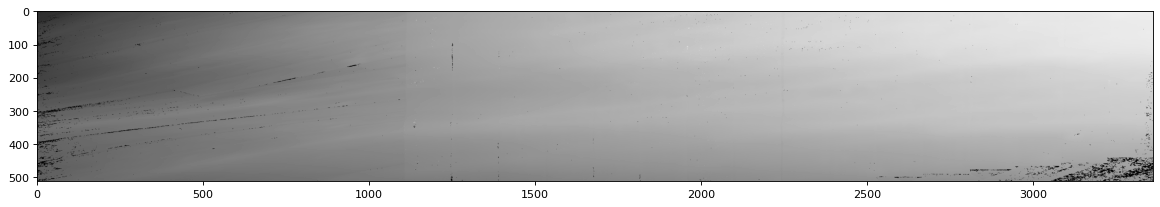

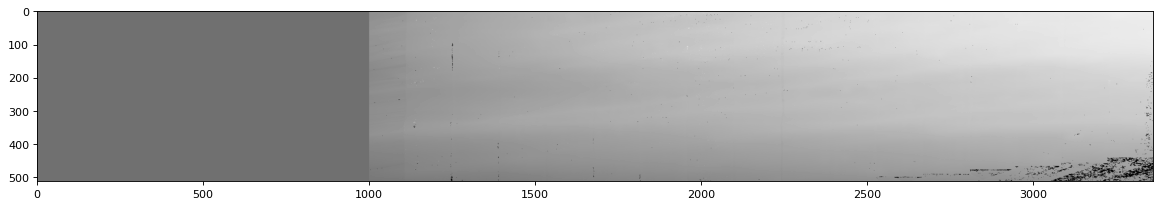

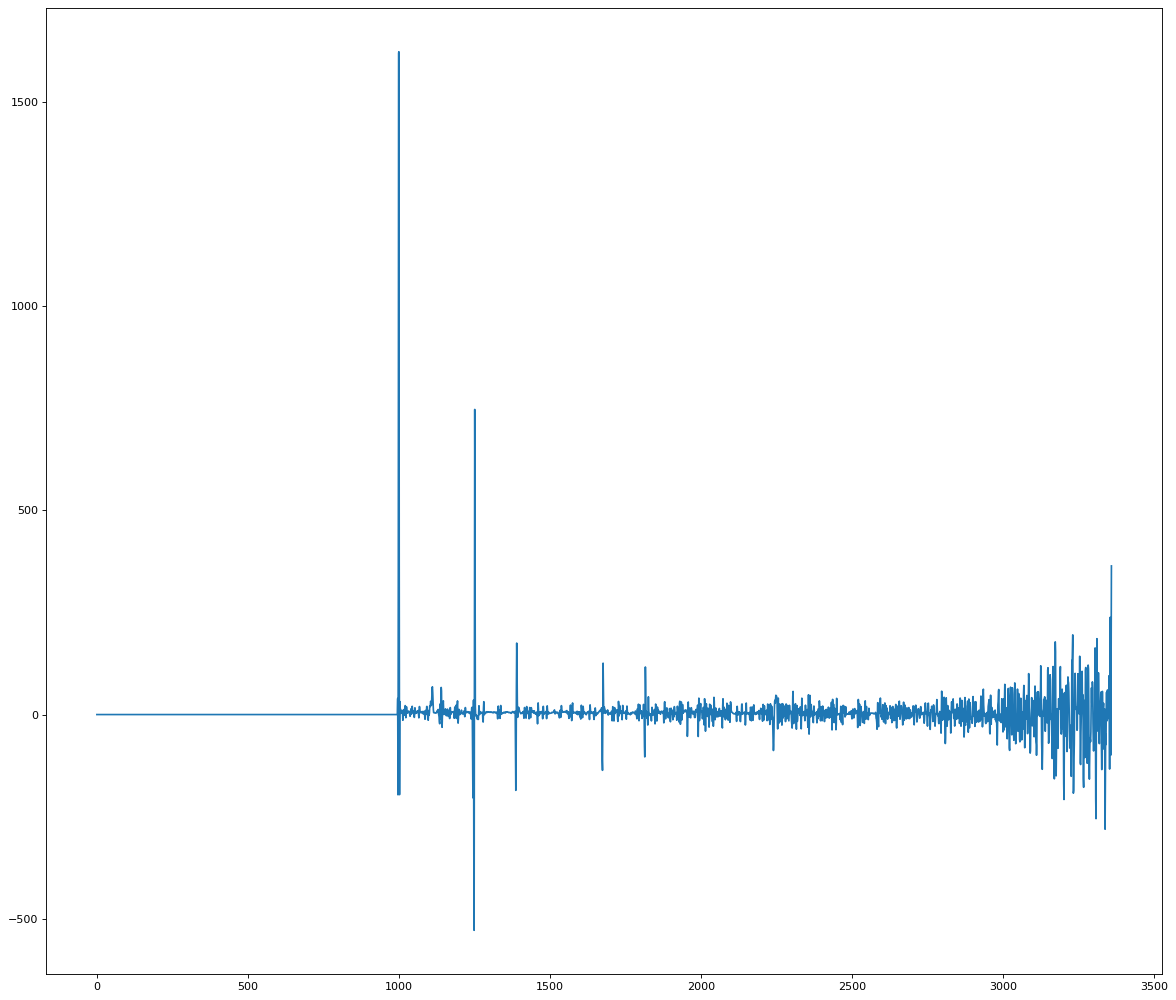

In [20]:
# sourceFolder = '/Users/zeekile/Desktop/Infy/source/20200422_afternoon_range_unconverted/'
sourceFolder = '/Users/zeekile/Desktop/Infy/nlr_data/goodRange/'
counter = 0
for fileName in os.listdir(sourceFolder): 
    if fileName.endswith(".png"):
        filePath = os.path.join(sourceFolder, fileName)
        img = cv2.imread(filePath, -1)
        imgOriginalCopy = np.copy(img)
        imgFilled = np.copy(img)
        img = imgFiltering(img)
        print('The file name is', fileName, \
             '\nThe image size', img.shape, \
             '\nThe whole image mean value:', np.mean(img), \
             '\nThe maximum value:', np.amax(img), \
             '\nThe minimum value:', np.amin(img), \
             '\n\nThe image left part, mean value:', np.mean(img[:, :1000]), \
             '\nThe image left part, max value:', np.amax(img[:, :1000]), \
             '\nThe image left part, min value:', np.amin(img[:, :1000]), \
             '\n\nThe image right part, mean value:', np.mean(img[:, 1000:]), \
             '\nThe image right part, max value:', np.amax(img[:, 1000:]), \
             '\nThe image right part, min value:', np.amin(img[:, 1000:]), \
             '\n-------------------------------------------------------\n')
        
        imgFilled[:, :1000].fill(np.mean(img[:, :1000]))
        plotImage(imgOriginalCopy)
        plotImage(imgFilled)

        # create a mean vertically
        means = np.mean(imgFilled, axis=0)
        smoothed = savgol_filter(means, 7, 5)
        # plotProfile(smoothed)

        gradientArr = np.gradient(smoothed)
        largeGradIndex = removeCloseGrad((np.nonzero(gradientArr>50))[0])
        towXs = filterAccordingToWidth(largeGradIndex)
        print(towXs)
        plotProfile(gradientArr)
        # plotProfile(np.diff(smoothed, n=3))
        plt.show()
    break